# 利民股份

2021年11月11日以来开启凌历上涨。

月线10月29日RSI22.78，上一月长上影（阳线，上影超10%）后极度缩量（24：6.4），当月下跌9.8%。

周线前两周RSI 21.09，下影接小阳线。

日线10月28 RSI 7，最低

## 30分钟线
    5，10，20，30，60粘合。11月10日 15：00，连续3周期收阳。股价位于上述均线之上。
    60周期线： 3e-5, 5e-4，3e-4
    
## 结果

```
0 	四环生物 	000518.XSHE 	2021-11-10 15:00
1 	汉森制药 	002412.XSHE 	2021-11-10 15:00
2 	贵州百灵 	002424.XSHE 	2021-11-10 15:00
3 	利民股份 	002734.XSHE 	2021-11-10 15:00
4 	奇信股份 	002781.XSHE 	2021-11-10 15:00
5 	香雪制药 	300147.XSHE 	2021-11-10 15:00
6 	长亮科技 	300348.XSHE 	2021-11-10 15:00
7 	海辰药业 	300584.XSHE 	2021-11-10 15:00
8 	欧亚集团 	600697.XSHG 	2021-11-10 15:00
9 	大参林 	603233.XSHG 	2021-11-10 15:00
10 	城地香江 	603887.XSHG 	2021-11-10 15:00
```
除利民股份外,效果都一般


In [1]:
from alpha.notebook import *
from alpha.core.rsi_stats import rsiday, rsi30
import datetime
import os
from omicron.models.stock import Stock
from coretypes import FrameType

await init_notebook()

In [ ]:
def ma30_group_trend(mas):
    mn = np.mean(mas, axis=0)
    (a, b, _), pmae = polyfit(mn)
    
    if pmae >= 3e-3:
        return 0
    
    if abs(a) < 3e-5 and b >= 3e-4:
        return 1
    
    if abs(a) < 3e-5 and b <= -5e-4:
        return -1
    
    return 0
def evaluate(code, month, week, day, m30):
    # 月线最低
    close = month["close"]
    rsi = relative_strength_index(close)
    if not any(rsi[-2:] < 25):
        return
    
    # 周线最低
    close = week["close"]
    rsi = relative_strength_index(close)
    if not any(rsi[-3:] < 25):
        return

    # 日线最低
    close = day["close"]
    rsi = relative_strength_index(close)
    if not any(rsi[-10:] < 10):
        return
    
    close = m30["close"]
    mas = []
    for win in [5, 10, 20, 30, 60]:
        ma = moving_average(close, win)[-20:]
        mas.append(ma/ma[0])
    
    mas = np.array(mas)
    if ma30_group_trend(mas) != 1:
        return
    
    bulls = close[-3:]/close[-4:-1] - 1
    if np.all(bulls) and np.all(close[-1] > mas[:,-1]):
        return True
        
    
async def scan(codes=None, tm=None):
    tm = arrow.get(tm) if tm else arrow.now()
    
    results = []
    if codes is None:
        codes = Stock.choose(['stock'])
        
    for code in codes:
        month = await get_bars(code, 30, '1M', tf.floor(tm, FrameType.MONTH))
        #print(month[-1]['frame'])
        
        week = await get_bars(code, 30, '1w', tf.floor(tm, FrameType.WEEK))
        #print(week[-1]['frame'])
        
        day = await get_bars(code, 100, '1d', tf.floor(tm, FrameType.DAY))
        #print(day[-1]['frame'])
        
        m30 = await get_bars(code, 100, '30m', tf.floor(tm, FrameType.MIN30))
        #print(m30[-1]['frame'])
        
        try:
            if evaluate(code, month, week, day, m30):
                name = Stock(code).display_name
                results.append((name, code, m30[-1]['frame'].strftime('%Y-%m-%d %H:%M')))
        except Exception as e:
            print(e)
            pass
            
    return pd.DataFrame(results, columns=["name", "code", "frame"])
        
df = await scan(tm = '2021-11-10 15:00')

In [ ]:
async def strategy(tm):
    tm = tf.day_shift(arrow.get(tm), 0)
    results = await scan(feature, 20, nstocks=-1, silent=True, tm=tm)
    #results = sorted(results, key=lambda x: x[-1])
    
    print("results:", len(results))
    print(results[0])
    profits = []
    end = tf.day_shift(tm, 21)
    for name, code, dt, *_ in results:
        bars = await get_bars(code, 23, end=end)
        profits.append((name, code, dt, *performance(bars, [1,3,5,8,10,15],stop_loss=0.1)))
        
    return profits
        
profits = await strategy("2021-08-30")
df = pd.DataFrame(profits, columns=["name", "code", "dt", "max", "min", "1", "3", "5", "8", "10", "15"])
df

In [ ]:
df.describe()

# 标本研究

In [14]:
lmgf = "002734.XSHE"
lmgf_30 = await get_bars(lmgf, 100, '30m', '2021-11-10 15:00')

In [15]:
lmgf_day = await get_bars(lmgf, 100, '1d', '2021-11-10')
lmgf_week = await get_bars(lmgf, 30, '1w', '2021-11-10')
lmgf_month = await get_bars(lmgf, 30, '1M', '2021-10-29')

In [16]:
for bars in [lmgf_30, lmgf_day, lmgf_week, lmgf_month]:
    close = bars["close"]
    rsi = relative_strength_index(close)
    print(rsi[-10:])

[71.38 85.34 53.84 46.91 42.53 42.53 37.49 51.33 66.78 73.88]
[ 8.68 20.77 31.08 26.22 29.02 39.98 36.98 36.05 49.67 49.67]
[  nan   nan 36.18 51.46 42.13 38.3  36.21 21.78 25.69 32.13]
[43.37 42.95 52.54 49.96 42.85 44.23 35.46 26.94 29.58 22.24]


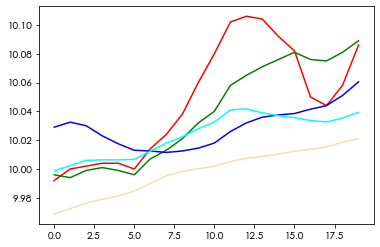

In [17]:
close = lmgf_30["close"]
mas = []
colors = {
    5: 'r',
    10:'g',
    20:'b',
    30:'cyan',
    60:'wheat'
}
for win in [5, 10, 20, 30, 60]:
    ma = moving_average(close, win)[-20:]
    mas.append(np.round(ma/ma[0], 3))
    plt.plot(ma, color = colors[win])
    
mas = np.array(mas)


In [ ]:
polyfit(mas[4])

In [ ]:
np.max(mas/mas[4]) - np.min(mas/mas[4])

In [ ]:
polyfit(np.mean(mas, axis=0))

In [ ]:
plt.plot(np.polyval([-7.758031442238378e-06, 0.0005021394395078156, 0.9992177922077918], np.arange(20)))
plt.plot(np.mean(mas, axis=0))